In [1]:
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import time
import numpy as np
import geopandas as gpd
import pandas as pd
from rasterstats import zonal_stats
import pandas as pd
import numpy as np
import folium
import streamlit as st
import geopandas as gpd
from pathlib import Path
from shapely.geometry import Point
from colour import Color
from shapely.geometry import box
from shapely.strtree import STRtree
import contextily as ctx
import seaborn as sns
import matplotlib.pyplot as plt
import random
%matplotlib inline

####setting seed for reproducibility
random.seed(42) 
np.random.seed(42)



Can't load requested DLL: C:\Users\linss\micromamba\envs\geoenv\Library\lib\gdalplugins\gdal_FITS.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Users\linss\micromamba\envs\geoenv\Library\lib\gdalplugins\gdal_FITS.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Users\linss\micromamba\envs\geoenv\Library\lib\gdalplugins\gdal_GRIB.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Users\linss\micromamba\envs\geoenv\Library\lib\gdalplugins\gdal_GRIB.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Users\linss\micromamba\envs\geoenv\Library\lib\gdalplugins\gdal_HDF4.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Users\linss\micromamba\envs\geoenv\Library\lib\gdalplugins\gdal_HDF4.dll
127: The specified procedure could not be found.

Can't load requested DLL: C:\Users\linss\micromamba\envs\geoenv\Library\lib\gdalplugins\

In [2]:
#load in population grid info. 
PROJECT_ROOT = Path().absolute().parent
DATA_DIR = PROJECT_ROOT / 'data'
RAW_DATA_DIR = DATA_DIR / 'raw'
PROCESSED_DATA_DIR = DATA_DIR / 'processed'
TEMP_DATA_DIR = DATA_DIR / 'temp'


population_info_raw=pd.read_csv(PROCESSED_DATA_DIR/'station_population_data.csv')
population_info_raw

,count,sum,nodata,grid_id,station_name,buffer_km,valid_pixels,nodata_pixels,total_pixels,prop_nodata,population_count
0,23,216.643463,87.0,21461,Aisa FM,20.0,23,87.0,110.0,0.790909,216.643463
1,58,700.665894,42.0,21291,Aisa FM,20.0,58,42.0,100.0,0.420000,700.665894
2,10,87.026184,111.0,21462,Aisa FM,20.0,10,111.0,121.0,0.917355,87.026184
3,80,864.314026,30.0,21292,Aisa FM,20.0,80,30.0,110.0,0.272727,864.314026
4,76,793.443115,45.0,21122,Aisa FM,20.0,76,45.0,121.0,0.371901,793.443115
...,...,...,...,...,...,...,...,...,...,...,...
9646,66,340.077698,55.0,12370,Dokolo FM,25.0,66,55.0,121.0,0.454545,340.077698
9647,51,233.072800,70.0,12200,Dokolo FM,25.0,51,70.0,121.0,0.578512,233.072800
9648,82,412.326538,39.0,12030,Dokolo FM,25.0,82,39.0,121.0,0.322314,412.326538
9649,56,270.777649,65.0,12201,Dokolo FM,25.0,56,65.0,121.0,0.537190,270.777649


             count          sum       nodata       grid_id    buffer_km  \
count  9651.000000  8708.000000  9651.000000   9651.000000  9651.000000   
mean     38.047042   302.580091    79.083100  14388.936172    23.048389   
std      21.657194   174.477512    21.854653   6034.514258     2.439239   
min       0.000000     3.802847     7.000000   6055.000000    20.000000   
25%      24.000000   200.612061    64.000000   9615.000000    20.000000   
50%      41.000000   283.750488    76.000000  11860.000000    25.000000   
75%      53.000000   381.442337    93.000000  20817.500000    25.000000   
max     114.000000  2563.534668   121.000000  26584.000000    25.000000   

       valid_pixels  nodata_pixels  total_pixels  prop_nodata  \
count   9651.000000    9651.000000   9651.000000  9651.000000   
mean      38.047042      79.083100    117.130142     0.675300   
std       21.657194      21.854653      5.815546     0.184109   
min        0.000000       7.000000    100.000000     0.057851   

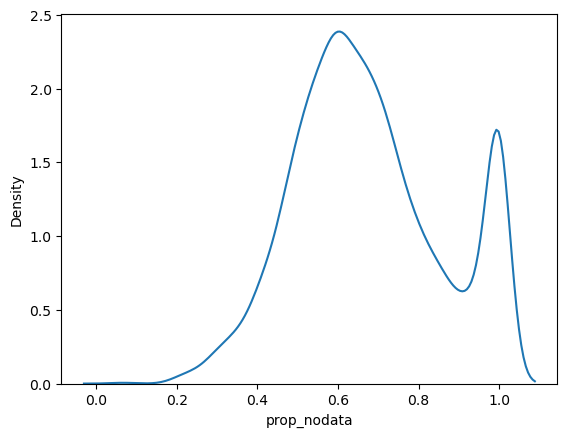

In [3]:
print(population_info_raw.describe())

sns.kdeplot(population_info_raw['prop_nodata'])
plt.show()

In [4]:
# open the gridded buffers (which has the polygons for each grid_id)
gridded_buffers_gdf=gpd.read_file(PROCESSED_DATA_DIR/'gridded_buffers_gdf.gpkg')
#select those grid cells where the proportion of nodata is lower than 0.8. Thus in at least one fifth of the pixels the cells should be inhabited. 
sampling_frame=population_info_raw

#how many cells left after excluding <=0.8? 
sampling_frame.groupby(['station_name','buffer_km']).size()

#let's take the 25km buffer. 
sampling_frame_25km=sampling_frame.loc[sampling_frame['buffer_km']==25.0]

In [5]:

#select only the grid id and grid geos. 

#prep grid id geo so that I can merge the geolocations with 


0.10673011556764106
628


population_count
NaN    628
Name: count, dtype: int64

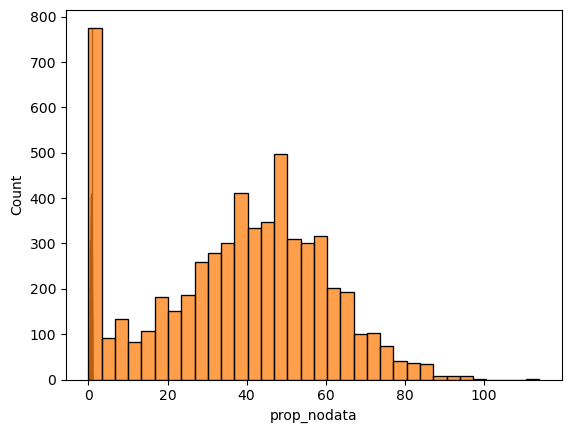

In [6]:
sns.histplot(data=sampling_frame_25km['prop_nodata'])
print(len(sampling_frame_25km.loc[sampling_frame_25km['prop_nodata']==1])/len(sampling_frame_25km))


sns.histplot(data=sampling_frame_25km['valid_pixels'])
sampling_frame_25km.loc[sampling_frame_25km['prop_nodata']>=0.9]

print(sampling_frame_25km['population_count'].isna().sum())

sampling_frame_25km.loc[sampling_frame_25km['population_count'].isna()].population_count.value_counts(dropna=False)


In [7]:
#replace nans with 0 in population count (these are uninhabited cells)
sampling_frame_25km.loc[:,'population_count']=sampling_frame_25km['population_count'].fillna(0)



In [8]:
def pps_sample_station(
    df: pd.DataFrame,
    station_name: str,
    n_clusters: int = 35,
    interviews_per_cluster=12,
    random_seed: int = 42
    
) -> pd.DataFrame:
    """
    Perform PPS sampling for a specific radio station using population count as size measure
    
    Parameters:
    -----------
    df : DataFrame with sampling frame data
    station_name : Name of the radio station to sample for
    n_clusters : Number of clusters to select
    random_seed : Random seed for reproducibility
    
    Returns:
    --------
    DataFrame with selected clusters and their weights
    """
    # Filter for specific station and copy to avoid modifying original
    station_df = df[df['station_name'] == station_name].copy()
    
    
    # Calculate selection probabilities based on population
    total_pop = station_df['population_count'].sum()
    station_df['selection_prob'] = station_df['population_count'] / total_pop
    
    # Calculate cumulative probabilities
    station_df['cumulative_prob'] = station_df['selection_prob'].cumsum()
    
    # Select clusters
    np.random.seed(random_seed)
    random_numbers = np.random.uniform(0, 1, n_clusters)
    
    selected_indices = []
    for r in random_numbers:
        selected = station_df[station_df['cumulative_prob'] >= r].index[0]
        selected_indices.append(selected)
    
    # Get selected clusters
    selected_clusters = station_df.loc[selected_indices].copy()
    
    # Calculate sampling weights
    selected_clusters['sampling_weight'] = 1 / selected_clusters['selection_prob']
    
    # Add sample size and total population info
    selected_clusters['interviews_per_cluster'] = interviews_per_cluster
    selected_clusters['total_population_covered'] = total_pop
    
    return selected_clusters



In [9]:
###draw sample
dfs = []
for station in sampling_frame_25km.station_name.unique(): 
    print(station)
    print()
    
    # Get all 70 clusters with PPS
    sample = pps_sample_station(sampling_frame_25km, station_name=station, n_clusters=70)
    
    # Add main/replacement designation just assign to main and replacement randomly.
    # Create balanced array of 35 main and 35 replacement
    cluster_types = np.array(['main']*35 + ['replacement']*35)
    np.random.shuffle(cluster_types)  # randomly shuffle the array
    sample['cluster_type'] = cluster_types # then assign that randomly shuffled array to a column
    
    print(sample.head())
    dfs.append(sample)
    
all_sampled_clusters = pd.concat(dfs)

# Optional: verify counts
print("\nFinal counts by station and type:")
print(all_sampled_clusters.groupby(['station_name', 'cluster_type']).size())


Aisa FM

      count         sum  nodata  grid_id station_name  buffer_km  \
1937     49  425.846130    72.0    24524      Aisa FM       25.0   
3051     82  661.170654    39.0    23364      Aisa FM       25.0   
2564     59  517.236816    62.0    18590      Aisa FM       25.0   
2303     82  730.694519    39.0    22674      Aisa FM       25.0   
1483     13   92.748978    97.0    20788      Aisa FM       25.0   

      valid_pixels  nodata_pixels  total_pixels  prop_nodata  \
1937            49           72.0         121.0     0.595041   
3051            82           39.0         121.0     0.322314   
2564            59           62.0         121.0     0.512397   
2303            82           39.0         121.0     0.322314   
1483            13           97.0         110.0     0.881818   

      population_count  selection_prob  cumulative_prob  sampling_weight  \
1937        425.846130        0.000662         0.374558      1511.477638   
3051        661.170654        0.001027       

In [10]:
#merge the sample with the.geo stuff so we know where these locations are. 
#grid_id_geo has non unique grid ids (the buffers for 20 km overlaps with the 25km buffer)
grid_id_geo_gdf=gridded_buffers_gdf[['grid_id', 'geometry']].drop_duplicates(subset='grid_id')




# Convert to geodataframe with left merge to maintain all sampled clusters
sampled_clusters_gdf = all_sampled_clusters.merge(
    grid_id_geo_gdf[['grid_id', 'geometry']], 
    on='grid_id',
    how='left'
)

# Convert to GeoDataFrame
sampled_clusters_gdf = gpd.GeoDataFrame(
    sampled_clusters_gdf, 
    geometry='geometry',
    crs=grid_id_geo_gdf.crs  # maintain the same CRS as your original geodataframe
)

#add the centord lat lon. 



In [ ]:
sampled_clusters_gdf
#add the centroid to the map. 



In [ ]:
sampled_clusters_gdf['centroid_lon_lat']= sampled_clusters_gdf.apply(
    lambda row: (row.geometry.centroid.x, row.geometry.centroid.y), 
    axis=1
)
#export the sampled clusters. 
sampled_clusters_gdf.to_file(PROCESSED_DATA_DIR / 'sampled_clusters.gpkg')

Index(['count', 'sum', 'nodata', 'grid_id', 'station_name', 'buffer_km',
       'valid_pixels', 'nodata_pixels', 'total_pixels', 'prop_nodata',
       'population_count', 'selection_prob', 'cumulative_prob',
       'sampling_weight', 'interviews_per_cluster', 'total_population_covered',
       'cluster_type', 'geometry', 'centroid_lon_lat'],
      dtype='object')

In [13]:
station_buffers_gdf=gpd.read_file(PROCESSED_DATA_DIR / 'station_buffers.gpkg')
station_loc_gdf=gpd.read_file(PROCESSED_DATA_DIR / 'station_loc.gpkg')



In [14]:
# Create map
m = folium.Map(location=[station_loc_gdf.geometry.y.mean(), station_loc_gdf.geometry.x.mean()], 
               zoom_start=10)

# Create legend
legend_html = """
<div style="position: fixed; 
            bottom: 50px; right: 50px; width: 200px; height: auto;
            background-color: white;
            border: 2px solid grey;
            z-index: 1000;
            padding: 10px;
            font-size: 14px;
            ">
<p><strong>Radio Stations</strong></p>
"""

# Add each station to the legend with its color
for idx, row in station_loc_gdf.iterrows():
    legend_html += f"""
    <p>
        <i class="fa fa-circle" style="color:{row['color']}"></i>
        {row['station_name']}
    </p>
    """
legend_html += "<p><strong>Assumed Coverage Ranges</strong></p>"
legend_html += """
<p>― 20km (solid line, highest opacity)</p>
<p>-- 25km (dashed line)</p>
<p>― ― 40km (long dashes)</p>
<p>... 60km (dotted line, lowest opacity)</p>
</div>
"""

m.get_root().html.add_child(folium.Element(legend_html))

# Create a Feature Group for each radio station's buffers
station_buffer_groups = {}
for station in station_loc_gdf['station_name'].unique():
    station_buffer_groups[station] = folium.FeatureGroup(name=f'Ranges {station}')

# Sort buffers from largest to smallest for proper layering
station_buffers_gdf = station_buffers_gdf.sort_values('buffer_km', ascending=False)

# Add buffers with different styles
for idx, row in station_buffers_gdf.iterrows():
    station_name = row['station_name']
    
    # Define style based on buffer size
    if row['buffer_km'] == 20:
        style = {
            'fillOpacity': 0.4, 
            'dashArray': None, 
            'weight': 2
        }
    elif row['buffer_km'] == 25:
        style = {
            'fillOpacity': 0.3, 
            'dashArray': '5,5', 
            'weight': 2
        }
    elif row['buffer_km'] == 40:
        style = {
            'fillOpacity': 0.2, 
            'dashArray': '10,10', 
            'weight': 2
        }
    else:  # 60km
        style = {
            'fillOpacity': 0.1, 
            'dashArray': '2,8', 
            'weight': 2
        }

    folium.GeoJson(
        row.geometry,
        style_function=lambda x, color=row['original_color'], style=style: {
            'fillColor': color,
            'color': color,
            'fillOpacity': style['fillOpacity'],
            'dashArray': style['dashArray'],
            'weight': style['weight']
        },
        highlight_function=lambda x: {
            'weight': 3,
            'fillOpacity': style['fillOpacity'] + 0.2
        },
        tooltip=f"{station_name} - {row['buffer_km']}km range",
        popup=folium.Popup(
            f"""
            <div style='width: 200px'>
                <b>{station_name}</b><br>
                Coverage Range: {row['buffer_km']} km<br>
            </div>
            """,
            max_width=300
        )
    ).add_to(station_buffer_groups[station_name])

# Add station points
for idx, row in station_loc_gdf.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=row['station_name'],
        tooltip=f"Click to see {row['station_name']} location",
        icon=folium.Icon(
            color='white',  
            icon_color=row['color'],
            icon='radio', 
            prefix='fa'
        )
    ).add_to(m)

# Add all buffer groups to the map
for group in station_buffer_groups.values():
    group.add_to(m)

# Add layer control
folium.LayerControl(collapsed=False).add_to(m)


In [15]:
m

In [16]:
import folium

# Create map
m = folium.Map(location=[station_loc_gdf.geometry.y.mean(), station_loc_gdf.geometry.x.mean()], 
               zoom_start=10)

# Create legend
legend_html = """
<div style="position: fixed; 
            bottom: 50px; right: 50px; width: 200px; height: auto;
            background-color: white;
            border: 2px solid grey;
            z-index: 1000;
            padding: 10px;
            font-size: 14px;
            ">
<p><strong>Radio Stations</strong></p>
"""

# Add each station to the legend with its color
for idx, row in station_loc_gdf.iterrows():
    legend_html += f"""
    <p>
        <i class="fa fa-circle" style="color:{row['color']}"></i>
        {row['station_name']}
    </p>
    """

# Add cluster types to legend
legend_html += """
<p><strong>Sampled Clusters</strong></p>
<p>█ Solid fill - Main clusters</p>
<p>▒ Dashed outline - Replacement clusters</p>
"""

legend_html += "<p><strong>Assumed Coverage Ranges</strong></p>"
legend_html += """
<p>― 20km (solid line, highest opacity)</p>
<p>-- 25km (dashed line)</p>
<p>― ― 40km (long dashes)</p>
<p>... 60km (dotted line, lowest opacity)</p>
</div>
"""

m.get_root().html.add_child(folium.Element(legend_html))

# Create feature groups for buffers and clusters
station_buffer_groups = {}
cluster_groups = {}
for station in station_loc_gdf['station_name'].unique():
    station_buffer_groups[station] = folium.FeatureGroup(name=f'Ranges {station}')
    cluster_groups[f'{station}_main'] = folium.FeatureGroup(name=f'Main Clusters - {station}')
    cluster_groups[f'{station}_replacement'] = folium.FeatureGroup(name=f'Replacement Clusters - {station}')

# Sort buffers from largest to smallest for proper layering
station_buffers_gdf = station_buffers_gdf.sort_values('buffer_km', ascending=False)

# Add buffers with different styles
for idx, row in station_buffers_gdf.iterrows():
    station_name = row['station_name']
    
    # Define style based on buffer size
    if row['buffer_km'] == 20:
        style = {
            'fillOpacity': 0.4, 
            'dashArray': None, 
            'weight': 2
        }
    elif row['buffer_km'] == 25:
        style = {
            'fillOpacity': 0.3, 
            'dashArray': '5,5', 
            'weight': 2
        }
    elif row['buffer_km'] == 40:
        style = {
            'fillOpacity': 0.2, 
            'dashArray': '10,10', 
            'weight': 2
        }
    else:  # 60km
        style = {
            'fillOpacity': 0.1, 
            'dashArray': '2,8', 
            'weight': 2
        }

    folium.GeoJson(
        row.geometry,
        style_function=lambda x, color=row['original_color'], style=style: {
            'fillColor': color,
            'color': color,
            'fillOpacity': style['fillOpacity'],
            'dashArray': style['dashArray'],
            'weight': style['weight']
        },
        highlight_function=lambda x: {
            'weight': 3,
            'fillOpacity': style['fillOpacity'] + 0.2
        },
        tooltip=f"{station_name} - {row['buffer_km']}km range",
        popup=folium.Popup(
            f"""
            <div style='width: 200px'>
                <b>{station_name}</b><br>
                Coverage Range: {row['buffer_km']} km<br>
            </div>
            """,
            max_width=300
        )
    ).add_to(station_buffer_groups[station_name])

# Ensure sampled clusters are in WGS84
sampled_clusters_gdf = sampled_clusters_gdf.to_crs(epsg=4326)

# Add clusters to the map
for station in sampled_clusters_gdf['station_name'].unique():
    # Get station color
    station_color = station_loc_gdf[station_loc_gdf['station_name'] == station]['color'].iloc[0]
    
    # Filter for this station
    station_clusters = sampled_clusters_gdf[sampled_clusters_gdf['station_name'] == station]
    
    # Add main clusters
    main_clusters = station_clusters[station_clusters['cluster_type'] == 'main']
    folium.GeoJson(
        main_clusters,
        style_function=lambda x, color=station_color: {
            'fillColor': color,
            'color': color,
            'weight': 2,
            'fillOpacity': 0.7
        },
        tooltip=folium.GeoJsonTooltip(
            fields=['station_name', 'cluster_type', 'population_count'],
            aliases=['Station', 'Type', 'Population'],
            style="background-color: white; color: black; font-family: arial; font-size: 12px; padding: 10px;"
        )
    ).add_to(cluster_groups[f'{station}_main'])
    
    # Add replacement clusters
    replacement_clusters = station_clusters[station_clusters['cluster_type'] == 'replacement']
    folium.GeoJson(
        replacement_clusters,
        style_function=lambda x, color=station_color: {
            'fillColor': color,
            'color': color,
            'weight': 1,
            'fillOpacity': 0.3,
            'dashArray': '5, 5'
        },
        tooltip=folium.GeoJsonTooltip(
            fields=['station_name', 'cluster_type', 'population_count'],
            aliases=['Station', 'Type', 'Population'],
            style="background-color: white; color: black; font-family: arial; font-size: 12px; padding: 10px;"
        )
    ).add_to(cluster_groups[f'{station}_replacement'])

# Add station points
for idx, row in station_loc_gdf.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=row['station_name'],
        tooltip=f"Click to see {row['station_name']} location",
        icon=folium.Icon(
            color='white',  
            icon_color=row['color'],
            icon='radio', 
            prefix='fa'
        )
    ).add_to(m)

# Add all groups to the map
for group in station_buffer_groups.values():
    group.add_to(m)
for group in cluster_groups.values():
    group.add_to(m)

# Add layer control
folium.LayerControl(collapsed=False).add_to(m)

In [17]:
m